In [1]:
from photochem import __version__
print(__version__)

0.6.2


# Gas Giant Tutorial

`Photochem` has an extension to the `EvoAtmosphere` class (the main photochemical model), that makes it easy to simulate gas giants. This tutorial demonstrates how to use the extension by reproducing the photochemical SO$_2$ in WASP-39b's atmosphere (a hot Jupiter) as described in [Tsai et al. (2023)](https://doi.org/10.1038/s41586-023-05902-2). Here are some planet and stellar properties and some package imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from astropy import constants

from photochem.utils import zahnle_rx_and_thermo_files
from photochem.extensions import gasgiants # Import the gasgiant extensions

class WASP39b:
    planet_radius = 1.279 # Jupiter radii
    planet_mass = 0.28 # Jupiter masses
    planet_Teq = 1166 # Equilibrium temp (K)
    stellar_radius = 0.932 # Solar radii
    stellar_Teff = 5400 # K
    stellar_metal = 0.01 # log10(metallicity)
    stellar_logg = 4.45 # log10(gravity), in cgs units

First we need to generate reaction and thermodynamic files that work well for gas giants. We can accomplish this with `zahnle_rx_and_thermo_files`, which starts with the main reaction file (`zahnle_earth.yaml`) and the trims out some unnecessary chemistry. Running this next cell produces two files: `photochem_rxns.yaml` for photochemistry/kinetics and `photochem_thermo.yaml` for thermodynamics. 

In [3]:
zahnle_rx_and_thermo_files(
    atoms_names=['H', 'He', 'N', 'O', 'C', 'S'], # We select a subset of the atoms in zahnle_earth.yaml (leave out Cl)
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml',
    remove_reaction_particles=True # For gas giants, we should always leave out reaction particles.
)

Note, fast chemistry can sometimes slow down or prevent the photochemical model from reaching a steady state. Sulfur chemistry in particular, is often problematic, but mostly for cooler planets than WASP-39b. If you have troubles reaching convergence, then perhaps remove "S3", "S4", "S8", and "S8aer", if these species are not extremely important:

```python
zahnle_rx_and_thermo_files(
    atoms_names=['H', 'He', 'N', 'O', 'C', 'S'], 
    exclude_species=['S3','S4','S8','S8aer'],
    remove_reaction_particles=True
)
```

If you don't care about sulfur species at all, then just omit "S" from `atoms_names`

```python
zahnle_rx_and_thermo_files(
    atoms_names=['H', 'He', 'N', 'O', 'C'],
    remove_reaction_particles=True
)
```

Next, we initialize the gas giant extension to the photochemical model, called `EvoAtmosphereGasGiant`.

In [4]:
planet_mass = WASP39b.planet_mass*constants.M_jup.value*1e3 # grams
planet_radius = WASP39b.planet_radius*constants.R_jup.value*1e2 # cm

pc = gasgiants.EvoAtmosphereGasGiant(
    'photochem_rxns.yaml',
    'WASP39b/WASP39b_flux.txt',
    planet_mass,
    planet_radius,
    solar_zenith_angle=83, # Used in Tsai et al. (2023)
    thermo_file='photochem_thermo.yaml'
)
pc.gdat.verbose = False # no printing

When modeling a gas giant, researchers often assume the planet has some composition relative to the Sun (i.e., a metallicity). The `EvoAtmosphereGasGiant` exention has a `ChemEquiAnalysis` object attached to it (`pc.gdat.gas`, see `from photochem.equilibrate import ChemEquiAnalysis` for details) for doing equilibrium chemistry calculations at depth in the gas giant atmosphere. This object contains an estimated composition of the Sun:

In [5]:
for i,atom in enumerate(pc.gdat.gas.atoms_names):
    print('%s %.2e'%(atom,pc.gdat.gas.molfracs_atoms_sun[i]))

H 9.21e-01
N 6.23e-05
O 4.51e-04
C 2.48e-04
S 1.21e-05
He 7.84e-02


The above solar composition is very reasonable, but below we change to the exact solar composition in Tsai et al. (2023) to best reproduce their results.

In [6]:
molfracs_atoms_sun = np.ones(len(pc.gdat.gas.atoms_names))*1e-10
comp = {
    'O': 5.37E-4,
    'C': 2.95E-4,
    'N': 7.08E-5,
    'S': 1.41E-5,
    'He': 0.0838,
    'H': 1
}
tot = sum(comp.values())
for key in comp:
    comp[key] /= tot
for i,atom in enumerate(pc.gdat.gas.atoms_names):
    molfracs_atoms_sun[i] = comp[atom]

pc.gdat.gas.molfracs_atoms_sun = molfracs_atoms_sun

Next, we establish several key variables
- The Pressure-Temperature profile. Here, we use the "morning" profile described in Tsai et al. (2023), computed with a GCM.
- The $K_{zz}$ profile (i.e., eddy diffusion). Here, we use the same values as Tsai et al. (2023).
- The metallicity. Like in Tsai et al. (2023), we assume a 10x solar value.
- The C/O ratio. Following Tsai et al. (2023), we assume the solar ratio.

In [7]:
# P-T profile from a GCM
P, T = np.loadtxt('WASP39b/atm_W39b_10Xsolar_Twhole_morning_TP_20deg.txt',skiprows=2).T

# Assumed Kzz (cm^2/s) in Tsai et al. (2023)
Kzz = np.ones(P.shape[0])
for i in range(P.shape[0]):
    if P[i]/1e6 > 5.0:
        Kzz[i] = 5e7
    else:
        Kzz[i] = 5e7*(5/(P[i]/1e6))**0.5

metallicity = 10.0 # 10x solar
CtoO = 1.0 # 1x solar

With these key values set, we can call `initialize_to_climate_equilibrium_PT`. This predicts an starting guess for the atmospheric composition using chemical equilibrium. The routine then builds an altitude grid for the photochemical model based on this initial chemistry.

In [8]:
pc.initialize_to_climate_equilibrium_PT(P, T, Kzz, metallicity, CtoO)

We can now integrate to a photochemical steady state. This can be most easily accomplished by calling `pc.find_steady_state()`, but below we instead integrate one step at a time, plotting the atmosphere as it evolves.

In [9]:
pc.initialize_robust_stepper(pc.wrk.usol)

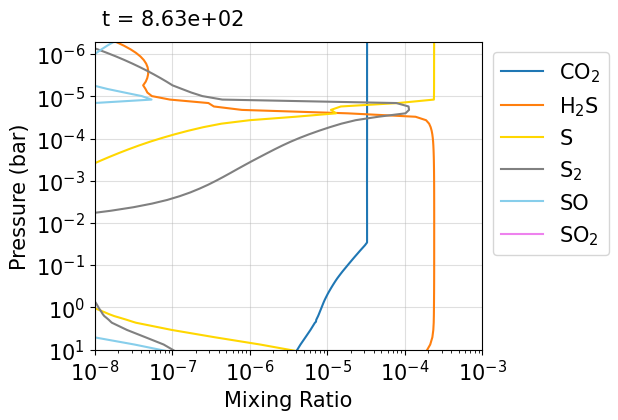

In [ ]:
while True:

    # Plot the atmosphere
    clear_output(wait=True)
    plt.rcParams.update({'font.size': 15})
    fig,ax = plt.subplots(1,1,figsize=[5,4])
    fig.patch.set_facecolor("w")

    sol = pc.return_atmosphere()
    soleq = pc.return_atmosphere(equilibrium=True)

    species = ['CO2','H2S','S','S2','SO','SO2']
    names = ['CO$_2$','H$_2$S','S','S$_2$','SO','SO$_2$']
    colors = ['C0','C1','gold','grey','skyblue','violet']
    for i,sp in enumerate(species):
        ax.plot(sol[sp],sol['pressure']/1e6,label=names[i],c=colors[i])
        # ax.plot(soleq[sp],soleq['pressure']/1e6,c=colors[i], ls=':', alpha=0.4)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-8,1e-3)
    ax.set_ylim(10,5e-7)
    ax.grid(alpha=0.4)
    ax.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
    ax.set_xlabel('Mixing Ratio')
    ax.set_ylabel('Pressure (bar)')
    ax.set_yticks(10.0**np.arange(-6,2))
    ax.text(0.02, 1.04, 't = '+'%.2e'%pc.wrk.tn, \
        size = 15,ha='left', va='bottom',transform=ax.transAxes)
    plt.show()

    # break

    for i in range(100):
        give_up, reached_steady_state = pc.robust_step()
        if give_up or reached_steady_state:
            break
    if give_up or reached_steady_state:
        break

The plot result reproduces Fig. 1a in Tsai et al. (2023).